# Use data from Vaishnav et al 2022 "Evolution" paper
Trying to approximate their results from a set of their training data

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import time


import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## load training data

In [3]:
data_filename = "data/defined_media_training_data.txt"
df = pd.read_csv(data_filename,sep='\t',header=None,names=['seq','expression'])
df

,seq,expression
0,TGCATTTTTTTCACATCTAGGTTATGACGCGCGTATATATTGACAT...,13.058197
1,TGCATTTTTTTCACATCAGTACGCCCAGGATCGTTCCTTTGGGCTA...,9.249105
2,TGCATTTTTTTCACATCCTCTTTTGGATTCATCGTTAGGAAGTACA...,10.000000
3,TGCATTTTTTTCACATCGATTCTAGTTTAGTTAGTTAACGTAAGGC...,10.000000
4,TGCATTTTTTTCACATCTATGACTAGGCAGAATAATTGCCATTCTA...,2.420605
...,...,...
21037402,TGCATTTTTTTCACATCTCTTAGACGTTTGCTTTGGAGATATTATC...,2.000000
21037403,TGCATTTTTTTCACATCATAAGGTGCCGTTAATTCGGTATTACTTA...,8.000000
21037404,TGCATTTTTTTCACATCATGAAGGATAGGAGGTAGGTACTTTTTGA...,7.151207
21037405,TGCATTTTTTTCACATCAAGCTGTTATGATTTTACTTTCTCTCGAA...,5.000000


In [4]:
df_05 = df.reset_index().rename(columns={'index':'og_index'}).sample(frac=0.05)
df_05

,og_index,seq,expression
16549025,16549025,TGCATTTTTTTCACATCCGTTAAGGATTTGCGGTGTCTTGTGGACG...,9.000000
8215705,8215705,TGCATTTTTTTCACATCTAGAATGAGTGATTAAGTAAATCTCTGGG...,10.000000
11033062,11033062,TGCATTTTTTTCACATCTTGAGGTCGCGGTGTGATACAAGTAGGAA...,14.000000
17288351,17288351,TGCATTTTTTTCACATCCCACTTATAGAGTTCGCAAGTGTTCTGGA...,13.000000
4935440,4935440,TGCATTTTTTTCACATCTCAATAGGGGGTACATGGGACAGCGCCGG...,9.737894
...,...,...,...
13227419,13227419,TGCATTTTTTTCACATCTTAAGTTTCCCGTATTTTCAAGATTTGTT...,9.000000
7788040,7788040,TGCATTTTTTTCACATCCCTGCTTGCCAATCCGTCTCTGTGCCGTT...,14.000000
10820273,10820273,TGCATTTTTTTCACATCTAACATGTATTGACCAGTCGAAAGTGTCC...,3.000000
10612659,10612659,TGCATTTTTTTCACATCTCACGCGATCACGATGTCTGAACACAGCG...,13.000000


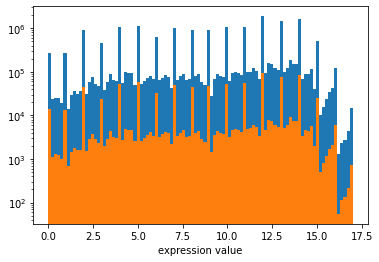

In [5]:
plt.hist(df['expression'].values,bins=100)
plt.hist(df_05['expression'].values,bins=100)
plt.xlabel("expression value")
plt.yscale('log')

In [6]:
df_05['shuffled_seq'] = df_05['seq'].apply(lambda x: u.shuffle_seq(x))
df_05

,og_index,seq,expression,shuffled_seq
16549025,16549025,TGCATTTTTTTCACATCCGTTAAGGATTTGCGGTGTCTTGTGGACG...,9.000000,AGTATAGCGAATTGTTTTTGATCTGCCGCGGTAATGCCGCTCCGGT...
8215705,8215705,TGCATTTTTTTCACATCTAGAATGAGTGATTAAGTAAATCTCTGGG...,10.000000,GAGTTCTCATCCGCTTTGATAGCTTAGTATTATCTTGTCGCTAGCA...
11033062,11033062,TGCATTTTTTTCACATCTTGAGGTCGCGGTGTGATACAAGTAGGAA...,14.000000,CATGTACGTTGGTTGTTCTACGGGTCATAACAAATGGTTTTGCTTT...
17288351,17288351,TGCATTTTTTTCACATCCCACTTATAGAGTTCGCAAGTGTTCTGGA...,13.000000,TTGCGGCTCTTCATGTCCGTAGGTGAGCGGTGGGAATGATTGTTCG...
4935440,4935440,TGCATTTTTTTCACATCTCAATAGGGGGTACATGGGACAGCGCCGG...,9.737894,TCACAACTCTTGGTGCTGGTGGGGAGCTTCTGGGTACGAGGTTATC...
...,...,...,...,...
13227419,13227419,TGCATTTTTTTCACATCTTAAGTTTCCCGTATTTTCAAGATTTGTT...,9.000000,TGTTGATCCGCGGGGTTTGCGTCATTCATATGGGTGTATTCTGTTA...
7788040,7788040,TGCATTTTTTTCACATCCCTGCTTGCCAATCCGTCTCTGTGCCGTT...,14.000000,GCGTTTGCGCCGTACGATTATGAGTGTCACCGCTTCTATGCATCCC...
10820273,10820273,TGCATTTTTTTCACATCTAACATGTATTGACCAGTCGAAAGTGTCC...,3.000000,GGCTCAGATTTCTAGAATAAAATAGACCTACGTCGTCTTGTTCCGT...
10612659,10612659,TGCATTTTTTTCACATCTCACGCGATCACGATGTCTGAACACAGCG...,13.000000,TCGTATGTTGCTAGACTCGTAGGATTGCATCGAACGGGTTACTGTT...


In [7]:
# For now, bump all sequences to length 300 (prev 127)
def fill_seq(seq,length):
    if len(seq) < length:
        num_ns = length - len(seq)
        ns = ''.join(["N" for x in range(num_ns)])
        return ns + seq
    elif len(seq) > length:
        raise ValueError(f"Length of seq is longer than {length} (is {len(seq)}).")
    else:
        return seq
    

In [8]:
# double check sequence lengths
print("min:",min([len(x) for x in df_05['seq'].values]))
print("max:",max([len(x) for x in df_05['seq'].values]))

min: 97
max: 127


In [9]:
fill_len = 300 # 127
df_05['seq'] = df_05['seq'].apply(lambda x: fill_seq(x,fill_len))
df_05['shuffled_seq'] = df_05['shuffled_seq'].apply(lambda x: fill_seq(x,fill_len))

In [10]:
print("min:",min([len(x) for x in df_05['seq'].values]))
print("max:",max([len(x) for x in df_05['seq'].values]))
df_05.head(10)

min: 300
max: 300


,og_index,seq,expression,shuffled_seq
16549025,16549025,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,9.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
8215705,8215705,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,10.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
11033062,11033062,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,14.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
17288351,17288351,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,13.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
4935440,4935440,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,9.737894,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
17075270,17075270,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,12.354647,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1960648,1960648,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,5.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
7357743,7357743,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,13.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
7705401,7705401,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,6.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
8723130,8723130,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,15.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


In [11]:
df_05.to_csv('data/defined_media_traning_data_0.05sample.txt',sep='\t',index=False)


## ** START HERE for reloading data and training

In [3]:
# reload the dataframe with only 1 million rows
df = pd.read_csv('data/defined_media_traning_data_0.05sample.txt',sep='\t')
df

,og_index,seq,expression,shuffled_seq
0,16549025,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,9.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1,8215705,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,10.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2,11033062,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,14.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3,17288351,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,13.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
4,4935440,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,9.737894,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
...,...,...,...,...
1051865,13227419,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,9.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1051866,7788040,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,14.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1051867,10820273,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,3.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1051868,10612659,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,13.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


## Create train val splits, randomly

In [4]:
df = df.reset_index()
train_df,val_df = tu.quick_split(df)
print(train_df.shape)
print(val_df.shape)

(841496, 6)
(210374, 6)


# 2. Run basic models for evolution expression - how far do we get?

In [5]:
model_res = {}
pred_dfs = {}

In [ ]:
target_col = 'expression'
seq_col = 'seq'
locus_col = 'index'


seq_len = len(train_df[seq_col].values[0])
    
# sequences to predict on after training
# just take 3% for now
split_dfs = {
    'train':train_df.sample(frac=0.03),
    'val':val_df.sample(frac=0.03)
}

# create data loaders
dataset_types = [
    DatasetSpec('ohe'),
]

dls = tu.build_dataloaders(
                train_df, 
                val_df, 
                dataset_types, # just OHE for now
                seq_col=seq_col,
                target_col=target_col,
            )
ohe_train_dl,ohe_val_dl = dls['ohe']


In [1]:
ohe_train_dl.keys()

NameError: name 'ohe_train_dl' is not defined

In [ ]:
# Kernel dies here, can't progress :( 

In [ ]:
m_args = (seq_len,1) # single task - regression
m_kwargs = {
    "num_filters1":32,
    "num_filters2":32,
    "kernel_size1":10,
    "kernel_size2":6,
    "conv_pool_size1":2,
    "fc_node_num1":50,
    "fc_node_num2":50,
    "dropout1":0.25
}

model = m.DNA_2CNN_2FC(*m_args,**m_kwargs)
model_name = f"evo_v1"

# +-------------+
# | TRAIN MODEL |
# +-------------+
t_res = tu.collect_model_stats(
    model_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=1000,
    pat=100,
    opt=torch.optim.Adam,
    model=model,
    loss_type='regression'
)

model_res[model_name] = t_res

In [ ]:
# +------------+
# | EVAL MODEL |
# +------------+
p_res_df = tu.parity_pred_by_split(
    model,
    model_name,
    DEVICE,
    split_dfs,
    locus_col=locus_col,
    seq_col=seq_col,
    target_col=target_col,
    splits=['train','val'],
    dense_color=True
)
p_res_df['model_type'] = "CNN"
p_res_df['seq_mode'] = "regular"
p_res_df['task'] = 'evo_regr'
#p_res_df['fold'] = i # which cv split
p_res_df['best_val_score'] = t_res['best_val_score']
p_res_df['epoch_stop'] = t_res['epoch_stop']
p_res_df['total_time'] = t_res['total_time']

pred_dfs[model_name] = p_res_df
    
    
    
    

In [ ]:
# Check training results here? Probs super slow... does the kernel crash?